In [12]:
import os
import PIL
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pydicom
import cv2
import scipy.ndimage

In [2]:
img_size = (224, 224)
min_slices = 28
normalize_img = 1
# three_channels = 1
channel_windows = ((0, 80), (-1000, 2000), (150, 200))

# Prepare Training Data

In [22]:
def read_serie_paths(chosen_scans):
    f = open(chosen_scans, "r")
    serie_list = []
    for serie_path in f.readlines():
        serie_path = serie_path.strip("\n")
        serie_list.append(serie_path)
    return serie_list

def read_labels(labels_file):
    csv = np.loadtxt(labels_file, delimiter=",", dtype=str)[1:]
    return csv

# TODO: save middle slices
def save_slices(serie_list, labels):
    for label in labels:
        exam_number = label[0]
        find = "/" + exam_number + "/"
        try:
            serie_path = next(serie for serie in serie_list if find in serie)
            exam_path = serie_path.split(exam_number)[0] + exam_number
            start_slice, end_slice, num_slices = middle_slices(serie_path)
            print("exam: " + str(exam_number) + " start: " + str(start_slice) + " end: " + str(end_slice) + " from: " + str(num_slices))
            save_slices_labels(exam_number, exam_path, label, start_slice, end_slice)
#           save_pngs_numpy(exam_number, exam_path, start_slice, end_slice)
            save_dicoms_numpy(exam_number, exam_path, serie_path, start_slice, end_slice)
        except StopIteration:
            pass
        
def save_slices_labels(exam_number, exam_path, label, start_slice, end_slice):
    labels_path = exam_path + "/labels/"
    os.makedirs(labels_path, exist_ok=True)
    if '1' in label[1:]: # com hemorragia
        label_info = {'exam_id': exam_number, 'label': True}
    else: # sem hemorragia
        label_info = {'exam_id': exam_number, 'label': False}
    for slice_index in range(start_slice, end_slice):
        img_label_filename = labels_path + 'scan_' + exam_number + '_slice_' + str(slice_index) + '.npy'
        np.save(img_label_filename, label_info)
            
def save_pngs_numpy(exam_number, exam_path, start_slice, end_slice):
    # create dir to store numpy image data
    npy_path = exam_path + "/numpy/"
    os.makedirs(npy_path, exist_ok=True)
    
    #now we generate data for slices in the range between start_slice and end_slice
    for slice_index in range(start_slice, end_slice):
        # Choose Between RGB or Windowed slices
        slice_path = exam_path + "/pngs/CT" + str(slice_index) + ".png"
        if normalize_img == 1: #normalize to 0~255
            slice_img = cv2.imread(slice_path)
            img_processed = 255 * (slice_img - np.amin(slice_img)) / (np.amax(slice_img) - np.amin(slice_img))      
        else:
            if three_channels == 1:
                slice_img = cv2.imread(slice_path, cv2.COLOR_BGR2GRAY)
                #first create an empty numpy array for the channeled ones
                img_processed = np.empty((img_size[0], img_size[1], len(channel_windows)))
                for c in range(0, len(channel_windows)):
                    img_processed[:, :, c] = create_channel(slice_img, channel_windows[c][0], channel_windows[c][1])        
            else:
                img_processed = slice_img
        #save this img_processed as a numpy array
        img_file_name = exam_path + '/numpy/' + 'scan_' + exam_number + '_slice_' + str(slice_index) + '.npy'
        np.save(img_file_name, img_processed)
        
def save_dicoms_numpy(exam_number, exam_path, series_path, start_slice, end_slice):
    # create dir to store numpy image data
    npy_path = exam_path + "/windowed/"
    os.makedirs(npy_path, exist_ok=True)
    
    #now we generate data for slices in the range between start_slice and end_slice
    for slice_index in range(start_slice, end_slice):
        # Choose Between RGB or Windowed slices
        slice_path = series_path + "/CT" + str(slice_index) + ".dcm"
        # gen image
        image = dcm_to_hu_224(slice_path)
        img_processed = stack_channels(image)
        #save this img_processed as a numpy array
        img_file_name = npy_path + 'scan_' + exam_number + '_slice_' + str(slice_index) + '.npy'
        np.save(img_file_name, img_processed)
        
def middle_slices(serie_path):
    # first get middle 28 slices
    num_slices = len(os.listdir(serie_path))
    start_slice = 0; end_slice = 28
    if num_slices > 28:
        middle = int(num_slices/2)
        start_slice = middle - 14
        end_slice = middle + 14
    else:
        end_slice = num_slices
    return start_slice, end_slice, num_slices

def dcm_to_hu_224(dcm_path):
    dcm_data = pydicom.read_file(dcm_path)
    img = dcm_data.pixel_array
    data = get_hu_values(dcm_data)
    xscale = 224/img.shape[0]
    yscale = 224/img.shape[1]
    return scipy.ndimage.interpolation.zoom(data, [xscale, yscale])

def stack_channels(image):
    channel1 = create_channel(image, 40, 80)
    channel2 = create_channel(image, 500, 3000)
    channel3 = create_channel(image, 175, 50)
    return np.stack((channel1, channel2, channel3), axis=2)

def get_hu_values(dcm_data):
    slope = float(dcm_data.RescaleSlope)
    intercept = float(dcm_data.RescaleIntercept)
    matrix = np.array(dcm_data.pixel_array)
    matrix = np.multiply(matrix, slope)
    matrix = np.add(matrix, intercept)
    return matrix

def create_channel(data, level, width):
    normalized = np.piecewise(data, [data <= (level -0.5 - (width - 1) / 2), data > (level - 0.5 + (width - 1) / 2)],
                                    [0, 255, lambda data: ((data - (level - 0.5)) / (width - 1) + 0.5) * (255 - 0)])
    return cv2.convertScaleAbs(normalized)

In [25]:
root_dir = "/home/rodrigo/processed-dataset/"
# root_dir = "/home/rodrigo/Batch/"
chosen_scans = root_dir + "GoodDirs.txt"
labels_file = root_dir + "labels-merged.csv"
# labels_file = root_dir + "labels-batch.csv"

serie_list = read_serie_paths(chosen_scans)
labels = read_labels(labels_file)
save_slices(serie_list, labels)
# exams lower than permited:
# 277 with 16
# 211 with 12
# 37 with 22
# 96 with 23
# 313 with 21
# 316 with 20
# 338 with 14
# 348 with 26
# 341 with 26
# 369 with 14
# 381 with 12
# 431 with 12
# TOTAL: 12

exam: 0 start: 1 end: 29 from: 30
exam: 1 start: 4 end: 32 from: 36
exam: 2 start: 2 end: 30 from: 32
exam: 3 start: 1 end: 29 from: 30
exam: 4 start: 4 end: 32 from: 36
exam: 7 start: 2 end: 30 from: 32
exam: 9 start: 4 end: 32 from: 36
exam: 11 start: 2 end: 30 from: 32
exam: 12 start: 4 end: 32 from: 36
exam: 13 start: 1 end: 29 from: 30
exam: 15 start: 2 end: 30 from: 32
exam: 17 start: 2 end: 30 from: 32
exam: 18 start: 2 end: 30 from: 32
exam: 19 start: 0 end: 28 from: 28
exam: 20 start: 4 end: 32 from: 36
exam: 21 start: 0 end: 28 from: 29
exam: 22 start: 1 end: 29 from: 30
exam: 23 start: 0 end: 28 from: 29
exam: 24 start: 2 end: 30 from: 32
exam: 25 start: 4 end: 32 from: 36
exam: 26 start: 1 end: 29 from: 30
exam: 27 start: 0 end: 28 from: 28
exam: 28 start: 4 end: 32 from: 36
exam: 29 start: 2 end: 30 from: 32
exam: 31 start: 1 end: 29 from: 30
exam: 32 start: 2 end: 30 from: 32
exam: 33 start: 2 end: 30 from: 32
exam: 34 start: 2 end: 30 from: 32
exam: 35 start: 4 end: 32 f

exam: 278 start: 1 end: 29 from: 30
exam: 279 start: 2 end: 30 from: 32
exam: 280 start: 1 end: 29 from: 30
exam: 281 start: 2 end: 30 from: 32
exam: 282 start: 2 end: 30 from: 32
exam: 283 start: 1 end: 29 from: 30
exam: 284 start: 1 end: 29 from: 30
exam: 285 start: 2 end: 30 from: 32
exam: 286 start: 1 end: 29 from: 30
exam: 287 start: 2 end: 30 from: 32
exam: 289 start: 1 end: 29 from: 30
exam: 290 start: 2 end: 30 from: 32
exam: 291 start: 2 end: 30 from: 32
exam: 292 start: 1 end: 29 from: 30
exam: 293 start: 1 end: 29 from: 30
exam: 294 start: 1 end: 29 from: 30
exam: 296 start: 3 end: 31 from: 34
exam: 297 start: 4 end: 32 from: 36
exam: 299 start: 2 end: 30 from: 32
exam: 300 start: 2 end: 30 from: 32
exam: 301 start: 2 end: 30 from: 32
exam: 302 start: 2 end: 30 from: 32
exam: 303 start: 1 end: 29 from: 30
exam: 305 start: 8 end: 36 from: 44
exam: 307 start: 9 end: 37 from: 46
exam: 308 start: 0 end: 28 from: 28
exam: 309 start: 4 end: 32 from: 36
exam: 310 start: 2 end: 30 f

# IGNORE TESTS BELOW

(224, 224, 3)
(512, 512)
ok
(512, 512, 3)


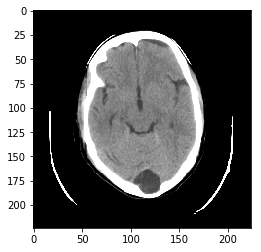

In [38]:
png_fn = '/home/rodrigo/Batch/0/pngs/CT11.png'
image = cv2.imread(png_fn)
print(image.shape)
imgplot = plt.imshow(image, cmap=plt.cm.bone)

dcm_fn = '/home/rodrigo/Batch/nifti/test-CT000000.dcm'
dataset = pydicom.dcmread(dcm_fn)
print(dataset.pixel_array.shape)
print("ok")

scan_fn = '/home/rodrigo/Batch/nifti/CQ500CT0_PLAIN_THIN.nii.gz'
img = nib.load(scan_fn)
img_data = img.get_data()
num_slice = img_data.shape[2]
print(img_data.shape)

# plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
# plt.show()

# Test Windowing

In [18]:
def get_lut(data, level, width):
    data = data * (1024)
    normalized = np.piecewise(data, [data <= (level -0.5 - (width - 1) / 2), data > (level - 0.5 + (width - 1) / 2)],
                                    [0, 255, lambda data: ((data - (level - 0.5)) / (width - 1) + 0.5) * (255 - 0)])
    return cv2.convertScaleAbs(normalized)


def create_channel(img, channel_min, channel_max):
    #this function will create channeled data based on the original single values data
    
    img_channel = img.copy()
    img_channel[img_channel <= channel_min] = 0
    img_channel[img_channel >= channel_max] = channel_max
    img_channel = 255 * (img_channel-np.amin(img_channel))/(np.amax(img_channel) - np.amin(img_channel))
    return img_channel

# png_fn = '/home/rodrigo/Batch/0/pngs/CT11.png'
# image = cv2.imread(png_fn)
# image = dataset.pixel_array
# print(image.shape)
# imgplot = plt.imshow(image, cmap=plt.cm.bone)

(224, 224, 3)


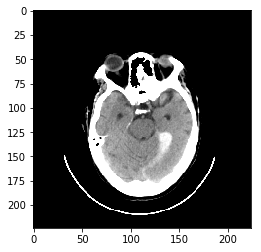

In [19]:
png_fn = '/home/rodrigo/Batch/159/pngs/CT11.png'
# image = cv2.imread(png_fn, cv2.COLOR_BGR2GRAY)
image = cv2.imread(png_fn)

# WINDOWING VALUES
#brain window: (l = 40, w = 80), i.e. 0~80 (everything <0 is 0, everything >80 is 255)
#bone window: (l = 500, w = 3000), i.e. -1000~2000
#subdural window: (l = 175, w = 50), i.e. 150~200

channel_param = ((0, 80), (-1000, 2000), (150, 200))
print(image.shape)
plt.imshow(image, cmap=plt.cm.bone)

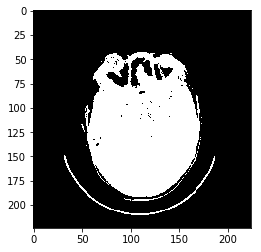

In [20]:
a = 70
b = 80
window = get_lut(image, a, b)
imgplot = plt.imshow(window)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


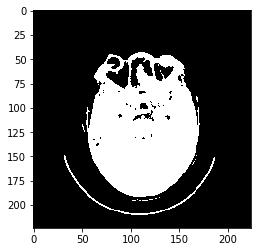

In [17]:
# pegar maior contorno e fazer alguma operação pra recuperar a hemorragia?
a = 70
b = 80
window = create_channel(image, a, b)
imgplot = plt.imshow(window)

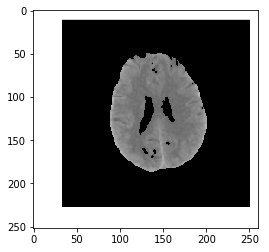

In [288]:
img3 = '/home/rodrigo/Videos/download (3).png'
image3= cv2.imread(img3)

plt.imshow(image3)